# Exposures class

#### What is an exposure?
Exposure describes the set of assets, people, livelihoods, infrastructures, etc. within an area of interest in terms of their geographic location, their value etc.; in brief - everything potentially exposed to hazards. 

<br>

#### What options does CLIMADA offer for me to create an exposure?
CLIMADA has an `Exposures` class for this purpuse. An `Exposures` instance can be filled with your own data, or loaded from available default sources implemented through some Exposures-type classes from CLIMADA. <br>
If you have your own data, they can be provided in the formats of a `pandas.DataFrame`, a `geopandas.GeoDataFrame` or simply an `Excel` file. 
If you didn't collect your own data, exposures can be generated on the fly using CLIMADA's [LitPop](climada_entity_LitPop.ipynb),  [BlackMarble](climada_entity_BlackMarble.ipynb) or  [OpenStreetMap](climada_entity_openstreetmap.ipynb) modules. See the respective tutorials to learn what exactly they contain and how to use them.

<br>

#### What does an exposure look like in CLIMADA?

An exposure is represented in the class `Exposures`, which is a [geopandas](https://geopandas.readthedocs.io/en/latest/gallery/cartopy_convert.html) [GeoDataFrame](https://geopandas.readthedocs.io/en/latest/data_structures.html#geodataframe).
There are certain variables in an `Exposures` instance that _have to_ be specified, while others are optional (this means that the package `climada.engine` also works without these variables set.) The full list looks like this:


| **Mandatory variables** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;| Data Type &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;| Description &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
| :- | :- | :- |
| **latitude** |(pd.Series)| latitude|
| **longitude** |(pd.Series)| longitude|
| **value** |(pd.Series)| a value for each exposure|

<br>
<br>

| Metadata optional variables &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;| Data Type&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; | Description &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
| :- | :- | :- |
| tag  |(Tag)| information about the source data |
| ref_year |(int)| reference year |
| value_unit |(str)| unit of the exposures values|

<br>
<br>

| Further optional variables | Data Type | Description|
| :- | :- | :- |
| if_*  | (pd.Series)| impact functions ids for hazard types. <br> important attribute, since it relates the exposures <br>to the hazard by specifying the impact functions. <br>Ideally it should be set to the specific hazard <br>(e.g. `if_TC`) so that different hazards <br>can be set in the same Exposures (e.g. `if_TC` and `if_FL`)<br> If not provided, set to  default `if_` with ids 1 in check().|
| geometry |(pd.Series)| geometry of type Point of each instance. <br>only needed to execute the methods of `geopandas` <br> Computed in method <br>`set_geometry_points()` |
| meta |(dict)| dictionary containing corresponding raster properties (if any): <br> width, height, crs and transform  must be present at least <br> (transform needs to contain upper left corner!).<br> Exposures might not contain all the <br> points of the corresponding raster.|
| deductible | (pd.Series) | deductible value for each exposure. <br> Used for insurance|
| cover | (pd.Series) | cover value for each exposure. <br> Used for insurance|
| category_id | (pd.Series) |  category id (e.g. building code) for each exposure|
| region_id | (pd.Series) | region id (e.g. country ISO code) for each exposure|
| centr_* | (pd.Series) |  centroids index for hazard type. <br>There might be different hazards defined: <br>centr_TC, centr_FL, ... <br>Computed in method `assign_centroids()`|


### How is this tutorial structured?

[**Part 1:**](#Part1) Defining exposures from your own data (DataFrame, GeoDataFrame, Excel)

[**Part 2:**](#Part2) Loading exposures from CLIMADA-files or generating new ones (LitPop, BlackMarble, OSM)

[**Part 3:**](#Part3) Visualizing exposures

[**Part 4:**](#Part4) Writing (=saving) exposures

[**Part 5:**](#Part5) What to do with large exposure data

<a id='Part1'></a> 
## Part 1: Defining exposures from your own data

The essential structure of an exposure is similar, irrespective of the data type you choose to provide: As mentioned in the introduction, the key variables to be provided are `latitude`s, `longitude`s and `value`s of your exposed assets. <br>
While not mandatory, but very useful to provide for the impact calculation at later stages: the impact function id (see `if_*` in the table above). <br>
The following examples will walk you through how to specifiy those four variables, and demonstrate the use of a few more optional parameters on the go.

### Exposures from a pandas DataFrame
In case you are unfamiliar with the data structure, check out the [pandas DataFrame documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [1]:
import numpy as np
from pandas import DataFrame
from climada.entity import Exposures

# Fill a pandas DataFrame with the 3 mandatory variables (latitude, longitude, value) for a number of assets (10'000).
# We will do this with random dummy data for purely illustrative reasons:
exp_df = DataFrame()
n_exp = 100*100
# provide value
exp_df['value'] = np.arange(n_exp)
# provide latitude and longitude
lat, lon = np.mgrid[15 : 35 : complex(0, np.sqrt(n_exp)), 20 : 40 : complex(0, np.sqrt(n_exp))]
exp_df['latitude'] = lat.flatten() 
exp_df['longitude'] = lon.flatten()

2020-10-12 12:09:35,426 - climada - DEBUG - Loading default config file: /Users/evelynm/climada_python/climada/conf/defaults.conf


/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# For each exposure entry, specify which impact function should be taken for which hazard type. 
# In this case, we only specify the IDs for tropical cyclone (TC); here, each exposure entry will be treated with 
# the same impact function: the one that has ID '1':
# Of course, this will only be relevant at later steps during impact calculations.
exp_df['if_TC'] = np.ones(n_exp, int) 

In [3]:
# Let's have a look at the pandas DataFrame
print('\x1b[1;03;30;30m' + 'exp_df is a DataFrame:', str(type(exp_df)) + '\x1b[0m')
print('\x1b[1;03;30;30m' + 'exp_df looks like:' + '\x1b[0m')
print(exp_df.head())

exp_df is a DataFrame: <class 'pandas.core.frame.DataFrame'>
exp_df looks like:
   value  latitude  longitude  if_TC
0      0      15.0  20.000000      1
1      1      15.0  20.202020      1
2      2      15.0  20.404040      1
3      3      15.0  20.606061      1
4      4      15.0  20.808081      1


In [4]:
# Generate Exposures from the pandas DataFrame. This step converts the DataFrame into
# a CLIMADA Exposures instance!
exp_df = Exposures(exp_df)
print('\n' + '\x1b[1;03;30;30m' + 'exp_df is now an Exposures:', str(type(exp_df)) + '\x1b[0m')

# set geometry attribute (shapely Points) from GeoDataFrame from latitude and longitude
exp_df.set_geometry_points()
print('\n' + '\x1b[1;03;30;30m' + 'check method logs:' + '\x1b[0m')

# always apply the check() method in the end. It puts metadata that has not been assigned, 
# and points out missing mandatory data
exp_df.check()


exp_df is now an Exposures: <class 'climada.entity.exposures.base.Exposures'>
2020-10-12 12:09:59,659 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-10-12 12:10:00,035 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-10-12 12:10:00,036 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-10-12 12:10:00,036 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-10-12 12:10:00,037 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2020-10-12 12:10:00,037 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-10-12 12:10:00,038 - climada.entity.exposures.base - INFO - centr_ not set.
2020-10-12 12:10:00,039 - climada.entity.exposures.base - INFO - deductible not set.
2020-10-12 12:10:00,039 - climada.entity.exposures.base - INFO - cover

In [5]:
# let's have a look at the Exposures instance we created!
print('\n' + '\x1b[1;03;30;30m'  + 'exp_df looks like:' + '\x1b[0m')
print(exp_df.head())


exp_df looks like:
   value  latitude  longitude  if_TC                   geometry
0      0      15.0  20.000000      1  POINT (20.00000 15.00000)
1      1      15.0  20.202020      1  POINT (20.20202 15.00000)
2      2      15.0  20.404040      1  POINT (20.40404 15.00000)
3      3      15.0  20.606061      1  POINT (20.60606 15.00000)
4      4      15.0  20.808081      1  POINT (20.80808 15.00000)


### Exposures from a geopandas GeoDataFrame

In case you are unfamiliar with with data structure, check out the [geopandas GeoDataFrame documentation](https://geopandas.readthedocs.io/en/latest/data_structures.html#geodataframe). <br>
The main difference to the example above (pandas DataFrame) is that, while previously, we provided latitudes and longitudes which were then converted to a `geometry` GeoSeries using the `set_geometry_points` method, GeoDataFrames alread come with a defined `geometry` GeoSeries. In this case, we take the geometry info and use the `set_lat_lon` method to explicitly provide latitudes and longitudes. <br>
This example focuses on data with POINT geometry, but in principle, other geometry types (such as POLYGON and MULTIPOLYGON) would work as well.

In [10]:
import numpy as np
import geopandas as gpd
from climada.entity import Exposures

# Read spatial info from an external file into GeoDataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
print('\x1b[1;03;30;30m' + 'World is a GeoDataFrame:', str(type(world)) + '\x1b[0m')
print('\x1b[1;03;30;30m' + 'World looks like:' + '\x1b[0m')
print(world.head())

World is a GeoDataFrame: <class 'geopandas.geodataframe.GeoDataFrame'>
World looks like:
           name                   geometry
0  Vatican City  POINT (12.45339 41.90328)
1    San Marino  POINT (12.44177 43.93610)
2         Vaduz   POINT (9.51667 47.13372)
3    Luxembourg   POINT (6.13000 49.61166)
4       Palikir  POINT (158.14997 6.91664)


In [11]:
# Generate Exposures: value, latitude and longitude for each exposure entry.
# Convert GeoDataFrame into Exposure instance
exp_gpd = Exposures(world)
print('\n' + '\x1b[1;03;30;30m' + 'exp_gpd is now an Exposures:', str(type(exp_gpd)) + '\x1b[0m')
# add random values to entries
exp_gpd['value'] = np.arange(world.shape[0])
# set latitude and longitude attributes from geometry
exp_gpd.set_lat_lon() 


exp_gpd is now an Exposures: <class 'climada.entity.exposures.base.Exposures'>
2020-10-12 14:02:18,668 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


In [12]:
# For each exposure entry, specify which impact function should be taken for which hazard type. 
# In this case, we only specify the IDs for tropical cyclone (TC); here, each exposure entry will be treated with 
# the same impact function: the one that has ID '1':
# Of course, this will only be relevant at later steps during impact calculations.
exp_gpd['if_TC'] = np.ones(world.shape[0], int) 
print('\n' + '\x1b[1;03;30;30m' + 'check method logs:' + '\x1b[0m')

# as always, run check method to assign meta-data and check for missing mandatory variables.
exp_gpd.check() 


check method logs:
2020-10-12 14:02:22,762 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-10-12 14:02:22,763 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-10-12 14:02:22,764 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-10-12 14:02:22,765 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2020-10-12 14:02:22,766 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-10-12 14:02:22,767 - climada.entity.exposures.base - INFO - centr_ not set.
2020-10-12 14:02:22,768 - climada.entity.exposures.base - INFO - deductible not set.
2020-10-12 14:02:22,770 - climada.entity.exposures.base - INFO - cover not set.
2020-10-12 14:02:22,771 - climada.entity.exposures.base - INFO - category_id not set.
2020-10-12 14:02:22,772 - climada.entity.exposures.base - INFO - reg

In [13]:
# let's have a look at the Exposures instance we created!
print('\n' + '\x1b[1;03;30;30m'  + 'exp_gpd looks like:' + '\x1b[0m')
print(exp_gpd.head())


exp_gpd looks like:
           name                   geometry  value   latitude   longitude  \
0  Vatican City  POINT (12.45339 41.90328)      0  41.903282   12.453387   
1    San Marino  POINT (12.44177 43.93610)      1  43.936096   12.441770   
2         Vaduz   POINT (9.51667 47.13372)      2  47.133724    9.516669   
3    Luxembourg   POINT (6.13000 49.61166)      3  49.611660    6.130003   
4       Palikir  POINT (158.14997 6.91664)      4   6.916644  158.149974   

   if_TC  
0      1  
1      1  
2      1  
3      1  
4      1  


The fact that `Exposures` is built on `geopandas.GeoDataFrame` offers all the useful functionalities that come with the package. The following examples showcase only a few of those.

In [27]:
# Example 1: extract data in a region: latitudes between -5 and 5
sel_exp = exp_gpd.cx[:, -5:5]
# Careful! After performing this operaton, the output is again a GeoDataFrame! You'd explicitly have to 
# set it to an Exposures() instance again, with Exposures(sel_exp)
print('\n' + '\x1b[1;03;30;30m' + 'sel_exp is now a:', str(type(sel_exp)) + '\x1b[0m')
sel_exp.head()


sel_exp is now a: <class 'geopandas.geodataframe.GeoDataFrame'>


,name,geometry,value,latitude,longitude,if_TC
9,Tarawa,POINT (173.01757 1.33819),9,1.338188,173.017571,1
13,Kigali,POINT (30.05859 -1.95164),13,-1.951644,30.058586,1
15,Juba,POINT (31.58003 4.82998),15,4.829975,31.580026,1
27,Bujumbura,POINT (29.36001 -3.37609),27,-3.376087,29.360006,1
48,Kampala,POINT (32.58138 0.31860),48,0.318605,32.581378,1


In [28]:
# Example 2: extract data in a polygon
from shapely.geometry import Polygon

poly = Polygon([(0, -10), (0, 10), (10, 5)])
sel_exp = exp_gpd[exp_gpd.intersects(poly)]

# Let's have a look. Again, the sub-selection is a GeoDataFrame!
print('\n' + '\x1b[1;03;30;30m' + 'sel_exp is now a:', str(type(sel_exp)) + '\x1b[0m')
sel_exp.head()


sel_exp is now a: <class 'geopandas.geodataframe.GeoDataFrame'>


,name,geometry,value,latitude,longitude,if_TC
36,Lome,POINT (1.22081 6.13388),36,6.133883,1.220811,1
84,Malabo,POINT (8.78328 3.75002),84,3.750015,8.783278,1
113,Cotonou,POINT (2.51804 6.40195),113,6.401954,2.518045,1
125,Sao Tome,POINT (6.73333 0.33340),125,0.333402,6.733325,1


In [29]:
# Example 3: change coordinate reference system
# use help to see more options: help(sel_exp.to_crs)
sel_exp.to_crs(epsg=3395, inplace=True) 
sel_exp.crs

/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


{'init': 'epsg:3395', 'no_defs': True}

In [30]:
# Example 4: concatenate exposures
import pandas as pd

exp_all = pd.concat([exp_templ, exp_df], ignore_index=True, sort=False)

# the output is of type Exposures
print('exp_all type and number of rows:', type(exp_all), exp_all.shape[0])

# NaNs will appear in the missing values
exp_all.tail()

exp_all type and number of rows: <class 'climada.entity.exposures.base.Exposures'> 10024


,latitude,longitude,value,deductible,cover,region_id,category_id,if_TC,centr_TC,if_FL,centr_FL,geometry
10019,35.0,39.191919,9995.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,POINT (39.19192 35.00000)
10020,35.0,39.393939,9996.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,POINT (39.39394 35.00000)
10021,35.0,39.595960,9997.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,POINT (39.59596 35.00000)
10022,35.0,39.797980,9998.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,POINT (39.79798 35.00000)
10023,35.0,40.000000,9999.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,POINT (40.00000 35.00000)


### Exposures of any file type supported by Geopandas and Pandas
Geopandas can read almost any vector-based spatial data format including ESRI shapefile, GeoJSON files and more, see [readers geopandas](http://geopandas.org/io.html). Pandas supports formats such as csv, html or sql; see [readers pandas](https://pandas.pydata.org/pandas-docs/stable/io.html). Using the corresponding readers, `DataFrame` and `GeoDataFrame` can be filled and provided to `Exposures` following the previous examples.

### Exposures from an excel file
If you manually collect exposure data, Excel may be your preferred option. <br>
In this case, it is easiest if you format your data according to the structure provided in the template  `climada_python/data/system/entity_template.xlsx`, in the sheet `assets`.

In [15]:
import pandas as pd
from climada.util.constants import ENT_TEMPLATE_XLS
from climada.entity import Exposures

# Read your Excel file into a pandas DataFrame (we will use the template example for this demonstration):
file_name = ENT_TEMPLATE_XLS 
exp_templ = pd.read_excel(file_name)

# Let's have a look at the data:
print('\x1b[1;03;30;30m' + 'exp_templ is a DataFrame:', str(type(exp_templ)) + '\x1b[0m')
print('\x1b[1;03;30;30m' + 'exp_templ looks like:' + '\x1b[0m')
print(exp_templ.head())

exp_templ is a DataFrame: <class 'pandas.core.frame.DataFrame'>
exp_templ looks like:
    latitude  longitude         value  deductible         cover  region_id  \
0  26.933899 -80.128799  1.392750e+10           0  1.392750e+10          1   
1  26.957203 -80.098284  1.259606e+10           0  1.259606e+10          1   
2  26.783846 -80.748947  1.259606e+10           0  1.259606e+10          1   
3  26.645524 -80.550704  1.259606e+10           0  1.259606e+10          1   
4  26.897796 -80.596929  1.259606e+10           0  1.259606e+10          1   

   category_id  if_TC  centr_TC  if_FL  centr_FL  
0            1      1         1      1         1  
1            1      1         2      1         2  
2            1      1         3      1         3  
3            1      1         4      1         4  
4            1      1         5      1         5  


As we can see, the general structure is the same as always: the exposure has `latitude`, `longitude` and `value` columns. Further, this example specified several impact function ids: some for Tropical Cyclones (`if_TC`), and some for Floods (`if_TC`). It also provides some meta-info (`region_id`, `category_id`) and insurance info relevant to the impact calculation in later steps (`cover`, `deductible`).

In [16]:
# Generate an Exposures instance from the dataframe.
exp_templ = Exposures(exp_templ)
print('\n' + '\x1b[1;03;30;30m' + 'exp_templ is now an Exposures:', str(type(exp_templ)) + '\x1b[0m')

# set geometry attribute (shapely Points) from GeoDataFrame from latitude and longitude
exp_templ.set_geometry_points() 
print('\n' + '\x1b[1;03;30;30m' + 'check method logs:' + '\x1b[0m')

# as always, run check method to include metadata and check for missing mandatory parameters
exp_templ.check() 


exp_templ is now an Exposures: <class 'climada.entity.exposures.base.Exposures'>
2020-10-12 14:17:37,165 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-10-12 14:17:37,177 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-10-12 14:17:37,178 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-10-12 14:17:37,179 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-10-12 14:17:37,180 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2020-10-12 14:17:37,180 - climada.entity.exposures.base - INFO - meta metadata set to default value: None


In [17]:
# Let's have a look at our Exposures instance!
print('\n' + '\x1b[1;03;30;30m'  + 'exp_templ looks like:' + '\x1b[0m')
print(exp_templ.head())


exp_templ looks like:
    latitude  longitude         value  deductible         cover  region_id  \
0  26.933899 -80.128799  1.392750e+10           0  1.392750e+10          1   
1  26.957203 -80.098284  1.259606e+10           0  1.259606e+10          1   
2  26.783846 -80.748947  1.259606e+10           0  1.259606e+10          1   
3  26.645524 -80.550704  1.259606e+10           0  1.259606e+10          1   
4  26.897796 -80.596929  1.259606e+10           0  1.259606e+10          1   

   category_id  if_TC  centr_TC  if_FL  centr_FL                    geometry  
0            1      1         1      1         1  POINT (-80.12880 26.93390)  
1            1      1         2      1         2  POINT (-80.09828 26.95720)  
2            1      1         3      1         3  POINT (-80.74895 26.78385)  
3            1      1         4      1         4  POINT (-80.55070 26.64552)  
4            1      1         5      1         5  POINT (-80.59693 26.89780)  


### Exposures from a raster file
Last but not least, you may have your exposure data stored in a raster file. Raster data may be read in from any file-type supported by [rasterio](https://rasterio.readthedocs.io/en/stable/). 

In [21]:
from rasterio.windows import Window
from climada.util.constants import HAZ_DEMO_FL

# We take an example with a dummy raster file (HAZ_DEMO_FL), running the method set_from_raster directly loads the 
# necessary info from the file into an Exposures instance.
exp_raster = Exposures()
exp_raster.set_from_raster(HAZ_DEMO_FL, window= Window(10, 20, 50, 60))
# There are several keyword argument options that come with the set_from_raster method (such as 
# specifying a window, if not the entire file should be read, or a bounding box. Check them out.

2020-10-12 14:25:45,613 - climada.util.coordinates - INFO - Reading /Users/evelynm/climada_python/data/demo/SC22000_VE__M1.grd.gz


In [22]:
# As always, run the check method, such that metadata can be assigned and checked for missing mandatory parameters.
exp_raster.check()
print('Meta:', exp_raster.meta)

2020-10-12 14:25:46,365 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-10-12 14:25:46,366 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2020-10-12 14:25:46,368 - climada.entity.exposures.base - INFO - Setting if_ to default impact functions ids 1.
2020-10-12 14:25:46,371 - climada.entity.exposures.base - INFO - centr_ not set.
2020-10-12 14:25:46,372 - climada.entity.exposures.base - INFO - deductible not set.
2020-10-12 14:25:46,373 - climada.entity.exposures.base - INFO - cover not set.
2020-10-12 14:25:46,374 - climada.entity.exposures.base - INFO - category_id not set.
2020-10-12 14:25:46,374 - climada.entity.exposures.base - INFO - region_id not set.
2020-10-12 14:25:46,375 - climada.entity.exposures.base - INFO - geometry not set.
Meta: {'driver': 'GSBG', 'dtype': 'float32', 'nodata': 1.701410009187828e+38, 'width': 50, 'height': 60, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0

In [23]:
# Let's have a look at the Exposures instance!
print('\n' + '\x1b[1;03;30;30m'  + 'exp_raster looks like:' + '\x1b[0m')
print(exp_raster.head())


exp_raster looks like:
   longitude   latitude  value  if_
0  -69.24265  10.243721    0.0    1
1  -69.23365  10.243721    0.0    1
2  -69.22465  10.243721    0.0    1
3  -69.21565  10.243721    0.0    1
4  -69.20665  10.243721    0.0    1


<a id='Part2'></a> 
## Part 2: Loading CLIMADA-generated exposure files or generating new ones

In case you already have a CLIMADA-generated file containing `Exposures` info, you can of course load it back into memory. Most likely, the data format will either be of `.hdf5` or of `.mat`.
<br>
In case you neither have your own data, nor a CLIMADA-generated file, you can also create an exposure on the fly using one of the three CLIMADA-internal exposure generators: [LitPop](climada_entity_LitPop.ipynb),  [BlackMarble](climada_entity_BlackMarble.ipynb) or  [OpenStreetMap](climada_entity_openstreetmap.ipynb) modules.
The latter three are extensively described in their own, linked, tutorials.

In [31]:
# read  generated with the Python version with read_hdf5()
# note: for .mat data, use the method read_mat() analogously.
from climada.util.constants import EXP_DEMO_H5

exp_hdf5 = Exposures()
exp_hdf5.read_hdf5(EXP_DEMO_H5)
exp_hdf5.check()
print(type(exp_hdf5))

2020-10-12 14:49:44,328 - climada.entity.exposures.base - INFO - Reading /Users/evelynm/climada_python/data/demo/exp_demo_today.h5
2020-10-12 14:49:46,963 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-10-12 14:49:46,964 - climada.entity.exposures.base - INFO - centr_ not set.
<class 'climada.entity.exposures.base.Exposures'>


### Before you leave ...
After defining an `Exposures` instance use always the `check()` method to see which attributes are missing. This method will raise an ERROR if `value`, `longitude` or `latitude` ar missing and an INFO messages for the the optional variables not set.

<a id='Part3'></a> 
## Part 3: Visualize Exposures

The method `plot_hexbin()` uses [cartopy](https://scitools.org.uk/cartopy/docs/v0.16/)  and [matplotlib's hexbin function](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hexbin.html) to represent the exposures values as 2d bins over a map. Configure your plot by fixing the different inputs of the method or by modifying the returned `matplotlib` figure and axes.

The method `plot_scatter()` uses cartopy and [matplotlib's scatter function](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.scatter.html) to represent the points values over a 2d map. As usal, it returns the figure and axes, which can be modify aftwerwards.

The method `plot_raster()` rasterizes the points into the given resolution. Use the `save_tiff` option to save the resulting `tiff` file and the `res_raster`option to re-set the raster's resolution.

Finally, the method `plot_basemap()` plots the scatter points over a satellite image using [contextily](https://github.com/darribas/contextily) library.

Plotting exp_df.


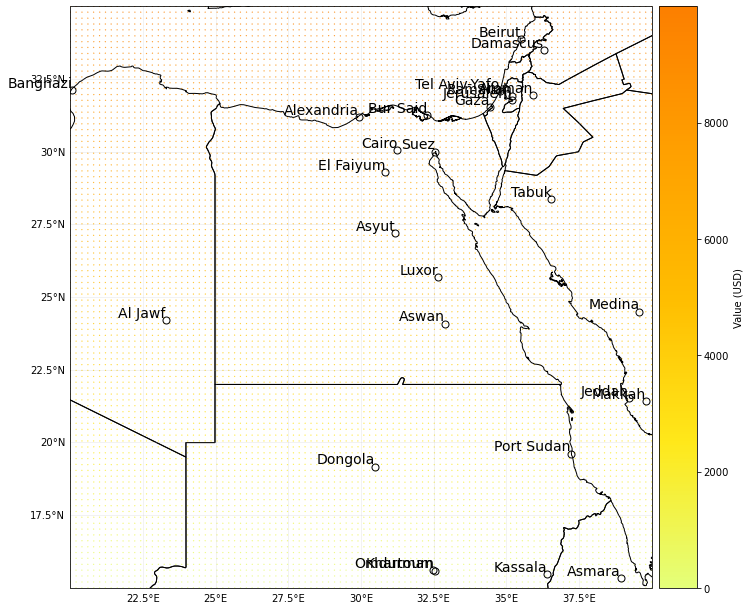

In [37]:
# Example 1: plot_hexbin method

print('\x1b[1;03;30;30m' + 'Plotting exp_df.' + '\x1b[0m')
axs = exp_df.plot_hexbin()

# further methods to check out: 
# axs.set_xlim(15, 45) to modify x-axis borders, axs.set_ylim(10, 40) to modify y-axis borders
# further keyword arguments to play around with: pop_name, buffer, gridsize, ...

2020-10-12 15:02:15,757 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/feature_artist.py:215: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **style)


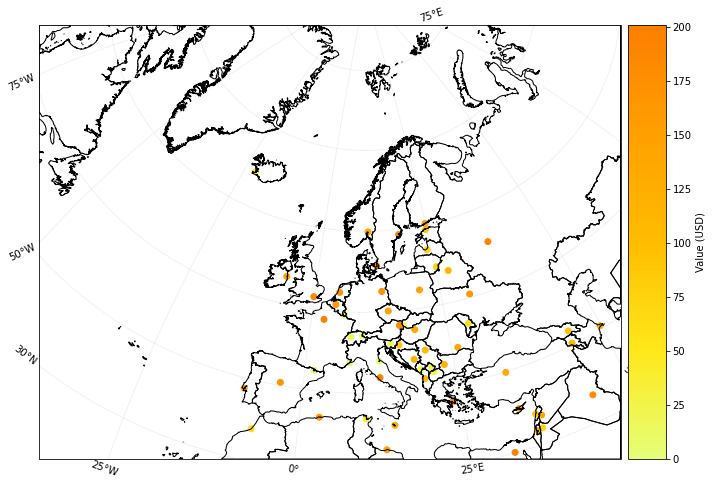

In [36]:
# Example 2: plot_scatter method

exp_gpd.to_crs({'init':'epsg:3035'}, inplace=True)
exp_gpd.plot_scatter(pop_name=False)

2020-10-12 15:09:17,307 - climada.util.coordinates - INFO - Raster from resolution 0.20202020202019355 to 0.20202020202019355.


/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/feature_artist.py:215: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **style)


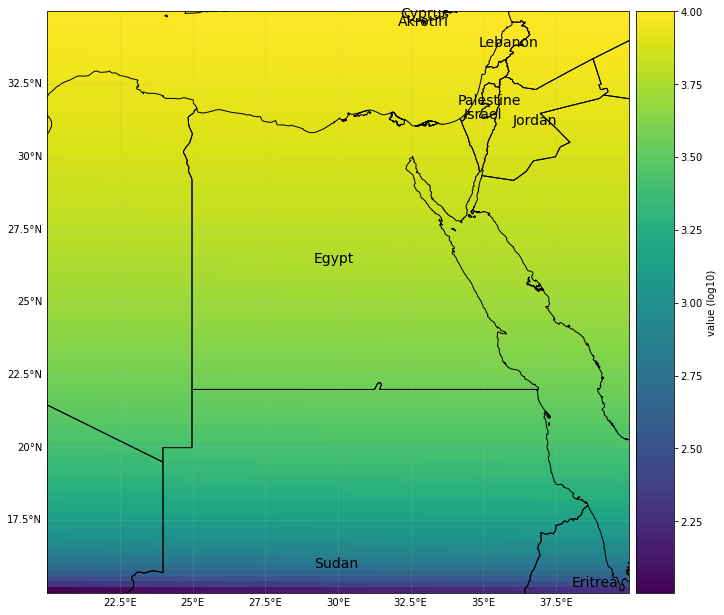

In [39]:
# Example 3: plot_raster method
from climada.util.plot import add_cntry_names # use climada's plotting utilities
ax = exp_df.plot_raster() # plot with same resolution as data
add_cntry_names(ax, [exp_df.longitude.min(), exp_df.longitude.max(), exp_df.latitude.min(), exp_df.latitude.max()])

# use keyword argument save_tiff='filepath.tiff' to save the corresponding raster in tiff format
# use keyword argument raster_res='desired number' to change resolution of the raster.

2020-10-12 15:06:56,572 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/evelynm/o

2020-10-12 15:07:01,291 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


AttributeError: module contextily.tile_providers has no attribute ST_WATERCOLOR

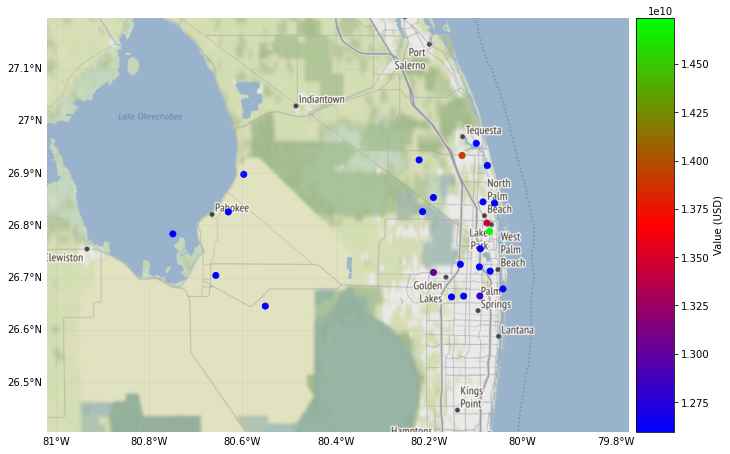

In [38]:
# Example 4: plot_basemap method
import contextily as ctx
# select the background image from the available ctx.sources
ax = exp_templ.plot_basemap(buffer=30000, cmap='brg') # using open street map
ax = exp_templ.plot_basemap(buffer=30000, url=ctx.sources.ST_WATERCOLOR, cmap='brg', zoom=9) # set image zoom

Since `Exposures` is a `GeoDataFrame`, any function for visualization from geopandas can be used. Check [making maps](https://geopandas.readthedocs.io/en/latest/mapping.html#) and [examples gallery](http://geopandas.org/gallery/index.html).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6a56f4310>]],
      dtype=object)

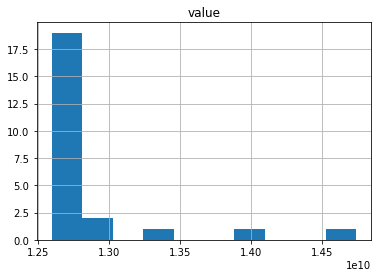

In [40]:
# other visualization types
exp_templ.hist(column='value')

<a id='Part4'></a> 
## Part 4: Write (Save) Exposures

Exposures can be saved in any format available for `GeoDataFrame` (see fiona.supported_drivers) and `DataFrame` ([pandas IO tools]('https://pandas.pydata.org/pandas-docs/stable/io.html')). Take into account that in many of these formats the metadata (e.g. variables `ref_year`, `value_unit` and `tag`) will not be saved. Use instead the format hdf5 provided by `Exposures` methods `write_hdf5()` and `read_hdf5()` to handle all the data.

In [41]:
import fiona; fiona.supported_drivers

# GeoDataFrame default: ESRI shape file in current path. metadata not saved!
exp_templ.to_file('results/exp_templ')

# DataFrame save to csv format. geometry writen as string, metadata not saved!
exp_templ.to_csv('results/exp_templ_csv', sep='\t')

In [42]:
# write as hdf5 file
exp_templ.write_hdf5('results/exp_temp.h5')

2020-10-12 15:17:11,792 - climada.entity.exposures.base - INFO - Writting results/exp_temp.h5


/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['geometry'], dtype='object')]

  exec(code_obj, self.user_global_ns, self.user_ns)


Finallly, as with any Python object, use climada's save option to save it in pickle format.

In [43]:
# save in pickle format
from climada.util.save import save
# this generates a results folder in the current path and stores the output there
save('exp_templ.pkl.p', exp_templ) # creates results folder and stores there

2020-10-12 15:17:22,560 - climada.util.save - INFO - Written file /Users/evelynm/climada_python/doc/tutorial/results/exp_templ.pkl.p


<a id='Part5'></a> 
## Part 5: Dask - improving performance for big exposure

Dask is used in some methods of CLIMADA and can be activated easily by proving the scheduler.

In [44]:
# set_geometry_points is expensive for big exposures
# for small amount of data, the execution time might be even greater when using dask
exp_df.drop(columns=['geometry'], inplace=True)
print(exp_df.head())
exp_df.set_geometry_points(scheduler='processes')
print(exp_df.head())

   value  latitude  longitude  if_TC
0      0      15.0  20.000000      1
1      1      15.0  20.202020      1
2      2      15.0  20.404040      1
3      3      15.0  20.606061      1
4      4      15.0  20.808081      1
2020-10-12 15:17:53,942 - climada.util.coordinates - INFO - Setting geometry points.
   value  latitude  longitude  if_TC                   geometry
0      0      15.0  20.000000      1  POINT (20.00000 15.00000)
1      1      15.0  20.202020      1  POINT (20.20202 15.00000)
2      2      15.0  20.404040      1  POINT (20.40404 15.00000)
3      3      15.0  20.606061      1  POINT (20.60606 15.00000)
4      4      15.0  20.808081      1  POINT (20.80808 15.00000)
